# Language Modeling Sequential


Let's try the language modeling task by using chariot and PyTorch.
When using PyTorch, we use sequential type data feeding.

* Download the WikiText2 dataset by chazutsu.
* Preprocess WikiText2 by chariot.
* Make model by PyTorch.
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* PyTorch
* matplotlib


## Prepare the packages

In [1]:
import os
import sys
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [4]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [5]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [6]:
import chariot.transformer as ct
from chariot.language_model_preprocessor import LanguageModelPreprocessor


dp = LanguageModelPreprocessor()
dp.process("sentence")\
    .by(ct.text.UnicodeNormalizer())\
    .by(ct.text.LowerNormalizer())\
    .by(ct.Tokenizer(lang=None))\
    .by(ct.Vocabulary(min_df=5))\
    .by(ct.generator.ShiftedTarget())\
    .fit(r.valid_data())

In [7]:
print(dp.process("sentence").preprocessor.vocabulary.count)

4321


## Make model by PyTorch

In [8]:
import torch
import torch.nn as nn


class LanguageModel(nn.Module):

    def __init__(self, ntoken, ninp, nhid, dropout=0.5):
        super(LanguageModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()
        self.nhid = nhid
        self.nlayers = 1

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

In [9]:
vocab_size = dp.process("sentence").preprocessor.vocabulary.count
embedding_size = 100
hidden_size = 100


model = LanguageModel(vocab_size, embedding_size, hidden_size)

c:\users\ico\documents\works\chariot\venv\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Train the Model

In [10]:
batch_size=20
sequence_length=35
criterion = nn.CrossEntropyLoss()
test_dataset = dp(r.test_data()).preprocess().format().processed


def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


def evaluate():
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(batch_size)
    iteration = 0
    with torch.no_grad():
        for data, targets in dp.iterate(test_dataset, batch_size=batch_size,
                                        sequence_length=sequence_length,
                                        epoch=1):

            data = torch.from_numpy(data).type(torch.LongTensor)
            targets = torch.from_numpy(targets).type(torch.LongTensor).contiguous().view(-1,)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, vocab_size)
            total_loss += criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
            iteration += 1
    return total_loss / iteration

In [11]:
model.train()
state = model.init_hidden(batch_size)
optimizer = torch.optim.Adam(model.parameters())

total_loss = 0
step_count = 0
epoch = 1
hidden = model.init_hidden(batch_size)
history = []

for batch in dp(r.test_data()).preprocess().iterate(batch_size=batch_size,
                                                    sequence_length=sequence_length,
                                                    epoch=10,
                                                    output_epoch_end=True):
    
    data, target, done = batch
    
    
    data = torch.from_numpy(data).type(torch.LongTensor)
    target = torch.from_numpy(target).type(torch.LongTensor).contiguous().view(-1,)
    optimizer.zero_grad()
    hidden = repackage_hidden(hidden)
    output, hidden = model(data, hidden)
    loss = criterion(output.view(-1, vocab_size), target)    
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    step_count += 1
    
    if done:
        _loss = total_loss / step_count
        test_loss = evaluate()
        metrics = {
            "loss": _loss,
            "perplexity": math.exp(_loss),
            "val_loss": test_loss,
            "val_perplexity": math.exp(test_loss)            
        }
        history.append(metrics)
        print("Epoch {}: loss={}, perplexity={} val_loss={}, val_perplexity={}.".format(
            epoch, metrics["loss"], metrics["perplexity"], metrics["val_loss"], metrics["val_perplexity"] ))
        epoch += 1
        total_loss = 0
        step_count = 0

Epoch 1: loss=4.851514079605324, perplexity=127.93394545739653 val_loss=4.418493055326994, val_perplexity=82.97115815734004.
Epoch 2: loss=4.411413138688997, perplexity=82.38580384916315 val_loss=4.379244617251462, val_perplexity=79.77774790415343.
Epoch 3: loss=4.34642846709074, perplexity=77.20223960911817 val_loss=4.300179691508759, val_perplexity=73.71303811663988.
Epoch 4: loss=4.26353247498357, perplexity=71.06056026701106 val_loss=4.2107171547967335, val_perplexity=67.40486220097891.
Epoch 5: loss=4.175541606060294, perplexity=65.07507517336013 val_loss=4.127957845150038, val_perplexity=62.05107555296066.
Epoch 6: loss=4.0920322890891585, perplexity=59.86142388667798 val_loss=4.050438612006431, val_perplexity=57.422637781127754.
Epoch 7: loss=4.014158767323162, perplexity=55.376691120614 val_loss=3.981068894613621, val_perplexity=53.574268880570706.
Epoch 8: loss=3.9434120918429176, perplexity=51.59434594853163 val_loss=3.9176543375780417, val_perplexity=50.282360895305565.
Epoc

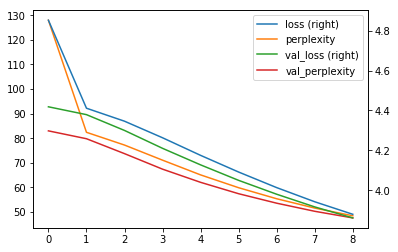

In [12]:
pd.DataFrame(history).plot.line(secondary_y=["loss", "val_loss"])